In [1]:
%load_ext autoreload
%pylab inline
%autoreload 2

import seaborn as sns
import pandas as pd
import numpy as np
import sys

sys.path.append('..')

Populating the interactive namespace from numpy and matplotlib


In [2]:
import tensorflow as tf
from tuning_manifold.fnp_model import Predictor
from tuning_manifold.util import negloglik, pearson

tfk = tf.keras

# construct a model with architecture matching the saved file
neurons = 16
stimuli = 2048 # make this longer because we draw additional samples to measure prediction
cell_latent_dim = 24
image_shape = [36, 64, 1]

architecture = [[17,16],[5,8],[3,4],[3,4],16,'same','batch']

inputs = [tfk.Input([stimuli, neurons], name='responses'), tfk.Input([stimuli, *image_shape], name='stimuli')]
predictor = Predictor(cell_latent_dim=cell_latent_dim, architecture=architecture, cummulative=True, contrastive_weight=0, l2_weight=0)

model = tfk.Model(inputs, predictor(inputs))
model.compile(loss=negloglik, metrics=[pearson, 'mse'], optimizer=tf.optimizers.Adam(learning_rate=1e-3, clipnorm=10))
model.load_weights('fnp_mouse_visual')

Architecture: [[17, 16], [5, 8], [3, 4], [3, 4], 16, 'same', 'batch']
Channel depth: 16
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


In [3]:
# Load data into memory. Follow instruction in the PNO directory to
# download the test dataset

from dataset import FileTreeDataset

dat = FileTreeDataset('../pno/data/Lurz2020/static20457-5-9-preproc0',  'images',  'responses')

trials = range(len(dat))
stimuli = np.stack([dat[i][0][0] for i in trials], axis=0)
responses = np.stack([dat[i][1] for i in trials], axis=0)

In [4]:
# compare to the same units used in the PNO experiment

test_units = np.load('20457-5-9_test_units.npy')
trials = dat.trial_info.tiers == 'train' # this indicates not repeated

test_stimuli = stimuli[np.newaxis,  trials, ..., np.newaxis].astype(np.float32)
test_responses = responses[np.newaxis, trials, ...][..., np.isin(dat.neurons.unit_ids, test_units) ].astype(np.float32)

In [5]:
# Can use the version of these in the predictor to use samples from
# distribution, or these to sample the mean (when testing)

import tensorflow as tf
import tensorflow_probability as tfp
from tuning_manifold.fnp_model import DeepSetSimple, HigherRankOperator, image_to_distribution
from tuning_manifold.util import interpolate_bilinear

tfk = tf.keras
tfpl = tfp.layers

predictor = model.layers[2]

location_predictor = predictor.location_predictor

# draw samples from the distribution and move them from the batch dimension
heatmap_to_dist_mean = tf.keras.layers.Lambda(lambda x: tf.expand_dims(image_to_distribution(x).mean(), axis=1))

mean_location_predictor = tfk.Sequential([
    # Perform convolution on each g-response image and output flattend version
    location_predictor.layers[0],
    # Exclusive set collapse
    DeepSetSimple(True),
    # Take the collapsed image and convert to distribution
    HigherRankOperator(heatmap_to_dist_mean)
], name='mean_location_predictor')

feature_mlp = predictor.feature_mlp
feature_mlp.layers[5] = tfpl.MultivariateNormalTriL(cell_latent_dim, convert_to_tensor_fn=lambda x: x.mean())

def compute_summary(predictor, inputs, return_im_feat=False, samples=1):
    responses, stimuli = inputs

    # convolve input stimuli
    g = predictor.im_conv_wrapper(stimuli)
    gr = predictor.crc([responses, g])

    sample_locations = mean_location_predictor(gr)

    # extract the image feature for each trial x neuron estimate of the location
    bs, stimuli, Ny, Nx, Nc = g.shape
    bs, stimuli, neurons, samples, coordinates = sample_locations.shape
    tf.assert_equal(coordinates, 2)
    im_feat = interpolate_bilinear(tf.reshape(g, [-1, Ny, Nx, Nc]),
                                   tf.reshape(sample_locations, [-1, neurons * samples, 2]))
    im_feat = tf.reshape(im_feat, [-1, stimuli, neurons, samples, Nc])

    # construct vector for each trial that includes information about the responses
    # and the feature, including a STA type response
    response_samples = tf.tile(responses[:, :, :, None, None], [1, 1, 1, samples, 1])
    x2 = tf.concat([im_feat, im_feat * response_samples, response_samples], axis=-1)

    # then let those interact through an MLP and then compute an average feature.
    # again for trial N this is computed only using information from the other
    # trials. This should compute a summary statistics describing a neuron (other
    # than the spatial location) based on those other trials.
    cell_summary = feature_mlp(x2)

    if not return_im_feat:
        return sample_locations, cell_summary
    else:
        return sample_locations, cell_summary, im_feat

In [6]:
def compute_rs(model, inputs, max_trial=1000, trials=[10, 25, 50, 100, 250, 500, 1000]):
    import scipy

    responses, stimuli = inputs
    
    r = responses[:,:max_trial,...]
    s = stimuli[:,:max_trial,...]
    
    predictor = model.layers[-1]
    sample_location, cell_summary = compute_summary(predictor, (r, s))
    im_conv = predictor.im_conv_wrapper.operator

    g = im_conv(stimuli[0, max_trial:])

    rs = []
    
    for trial in trials:

        trial_sample_locations = sample_location[0, -1, :, 0, :]
        w, b = cell_summary[0, trial-1, :, 0, :-1], cell_summary[0, trial-1, :, 0, -1]
        w = tf.expand_dims(w, 0)
        b =  tf.expand_dims(b, 0)


        locations = tf.reshape(trial_sample_locations, [1, trial_sample_locations.shape[0], trial_sample_locations.shape[-1]])
        locations = tf.tile(locations, [g.shape[0], 1, 1])

        im_feat = interpolate_bilinear(g, locations)

        t = tf.reduce_sum(tf.multiply(im_feat, w), axis=-1) + b
        t = tf.nn.elu(t) + 1
        
        r = [scipy.stats.pearsonr(responses[0, max_trial:, i], t[:, i].numpy())[0] for i in range(t.shape[1])]
        rs.append(r)

    return trials, np.array(rs)

In [7]:
all_rs = []
for i in np.arange(0, 1000, 10):
    trials, rs = compute_rs(model, (test_responses[:, :, i:i+10], test_stimuli),
                            max_trial=1024, trials=np.arange(25,1025,25))
    all_rs.append(rs)
    
all_rs = np.concatenate(all_rs, axis=1)

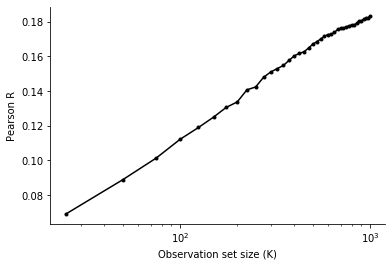

In [8]:
plt.semilogx(trials, np.mean(all_rs, axis=1), 'k.-')
plt.xlabel('Observation set size (K)')
plt.ylabel('Pearson R');

sns.despine(trim=False)